# Обучение с учителем: качество модели

## Содержание
<a href='#section1'> 2. Описание проекта </a> <br>
<a href='#section2'> 3. Описание данных </a> <br>
<a href='#section3'> 4. Загрузка данных </a> <br>
<a href='#section4'> 5. Предобработка данных </a> <br>
<a href='#section5'> 6. Исследовательский анализ данных </a> <br>
<a href='#section6'> 7. Объединение таблиц </a> <br>
<a href='#section7'> 8. Корреляционный анализ </a> <br>
<a href='#section8'> 9. Использование пайплайнов </a> <br>
<a href='#section9'> 10. Анализ важности признаков </a> <br>
<a href='#section10'> 11. Сегментация покупателей </a> <br>
<a href='#section11'> 12. Общий вывод </a> <br>

<a id='section1'></a>
## Описание проекта
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.<br> <br>
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. <br> <br>
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.<br> <br>
Продумывать подход к решению этой задачи вам не придётся — руководитель отдела его уже сформировал:
1. Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
2. Нужно собрать данные по клиентам по следующим группам:
    - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
    - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
    - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
    - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.
3. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
4. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
5. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

Руководство одобрило описание решения, и вам, как специалисту по DS, нужно его реализовать.

In [1]:
!pip install matplotlib==3.5.0 -q

In [2]:
!pip install -Uq scikit-learn

In [3]:
!pip install shap -q

In [4]:
!pip install phik -q

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score

import shap
from phik.report import plot_correlation_matrix
from phik import report

<a id='section2'></a>
## Описание данных
Данные для работы находятся в нескольких таблицах. <br>
1. market_file.csv Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении: 
    - id — номер покупателя в корпоративной базе данных.
    - Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
    - Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
    - Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
    - Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
    - Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
    - Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
    - Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
    - Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
    - Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
    - Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
    - Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
    - Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
2. market_money.csv Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом:
    - id — номер покупателя в корпоративной базе данных.
    - Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
    - Выручка — сумма выручки за период. 
3. market_time.csv Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода:
    - id — номер покупателя в корпоративной базе данных.
    - Период — название периода, во время которого зафиксировано общее время.
    - минут — значение времени, проведённого на сайте, в минутах.
4. money.csv Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю:
    - id — номер покупателя в корпоративной базе данных.
    - Прибыль — значение прибыли

<a id='section3'></a>
## Загрузка данных

In [6]:
try:
    market_file = pd.read_csv('market_file.csv', sep=',', decimal='.')
    market_money = pd.read_csv('market_money.csv', sep=',', decimal='.')
    market_time = pd.read_csv('market_time.csv', sep=',', decimal='.')
    money = pd.read_csv('money.csv', sep=';', decimal=',')
except:
    market_file = pd.read_csv('/datasets/market_file.csv', sep=',', decimal='.')
    market_money = pd.read_csv('/datasets/market_money.csv', sep=',', decimal='.')
    market_time = pd.read_csv('/datasets/market_time.csv', sep=',', decimal='.')
    money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

In [7]:
market_file.info()
market_file.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [8]:
market_money.info()
market_money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [9]:
market_time.info()
market_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [10]:
money.info()
money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<a id='section4'></a>
## Предобработка данных

In [11]:
market_file.columns = market_file.columns.str.replace(' ', '_')
market_file.columns

Index(['id', 'Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

In [12]:
market_file['Покупательская_активность'] = market_file['Покупательская_активность'].str.lower()
market_file['Популярная_категория'] = market_file['Популярная_категория'].str.lower()
market_file['Тип_сервиса'] = market_file['Тип_сервиса'].str.replace('стандартт', 'стандарт')
market_file['Популярная_категория'] = market_file['Популярная_категория'].str.replace(' ', '_')

In [13]:
market_file.isna().sum()

id                                     0
Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [14]:
market_file[market_file.duplicated()].sum()

id                                     0.0
Покупательская_активность              0.0
Тип_сервиса                            0.0
Разрешить_сообщать                     0.0
Маркет_актив_6_мес                     0.0
Маркет_актив_тек_мес                   0.0
Длительность                           0.0
Акционные_покупки                      0.0
Популярная_категория                   0.0
Средний_просмотр_категорий_за_визит    0.0
Неоплаченные_продукты_штук_квартал     0.0
Ошибка_сервиса                         0.0
Страниц_за_визит                       0.0
dtype: float64

In [15]:
market_money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

In [16]:
market_money[market_money.duplicated()].sum()

id         0.0
Период     0.0
Выручка    0.0
dtype: float64

In [17]:
market_time.columns = market_time.columns.str.replace('минут', 'Минуты')

In [18]:
market_time.isna().sum()

id        0
Период    0
Минуты    0
dtype: int64

In [19]:
market_time[market_time.duplicated()].sum()

id        0.0
Период    0.0
Минуты    0.0
dtype: float64

In [20]:
market_time['Период'] = market_time['Период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')

In [21]:
money.isna().sum()

id         0
Прибыль    0
dtype: int64

In [22]:
money[money.duplicated()].sum()

id         0.0
Прибыль    0.0
dtype: float64

In [23]:
market_file.head()

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2


In [24]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [25]:
market_time.head()

,id,Период,Минуты
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


In [26]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Итог:
- Названия столбцов приведены к одному виду
- Устранены опечатки в данных
- Данные проверены на дубликаты
- Данные проверены на пропуски

<a id='section5'></a>
## Исследовательский анализ данных

### market_file

In [27]:
col_features = ['Маркет_актив_6_мес', 
                'Маркет_актив_тек_мес', 
                'Длительность',
                'Акционные_покупки', 
                'Средний_просмотр_категорий_за_визит',
                'Неоплаченные_продукты_штук_квартал', 
                'Ошибка_сервиса',
                'Страниц_за_визит']
cat_features = ['Покупательская_активность', 
                'Тип_сервиса', 
                'Разрешить_сообщать',
                'Популярная_категория']

#### Категориальные признаки

In [28]:
def plot_cat(df, column):
    plt.figure(figsize=(7, 3.5))
    inf = df[column].value_counts()
    if column == 'Популярная_категория':
        ax = sns.barplot(x=inf, y=inf.index)
    else:
        ax = sns.barplot(x=inf.index, y=inf)
    ax.set_ylabel('Частота')
    ax.set_title(column)
    plt.show()

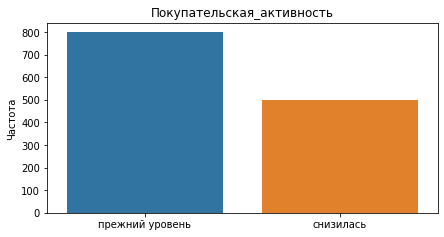

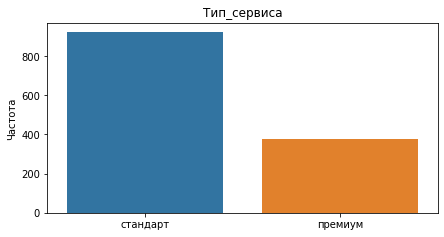

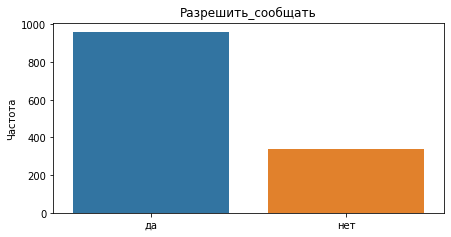

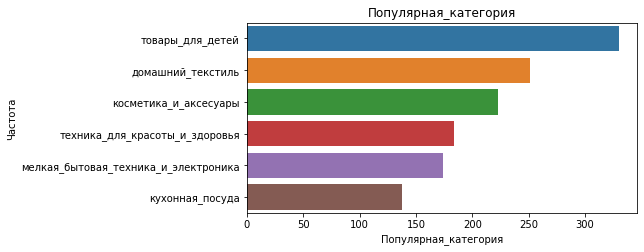

In [29]:
for i in cat_features:
    plot_cat(market_file, i)

#### Количественные признаки

In [30]:
def plot_col(df, column, name=''):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 2, 1)
    plt.ylabel('Частота')
    if name != '':
        plt.title(f'{column} {name}')
    else:
        plt.title(f'{column}')
    sns.histplot(df[column])
    plt.subplot(1, 2, 2)
    if name != '':
        plt.title(f'{column} {name}')
    else:
        plt.title(f'{column}')
    sns.boxplot(x=df[column])

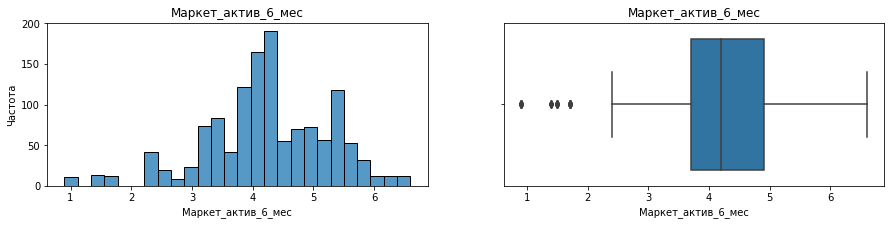

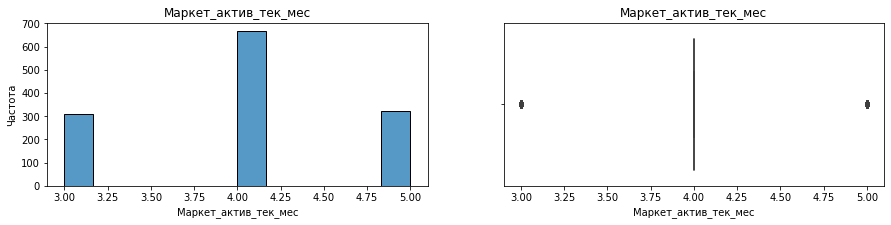

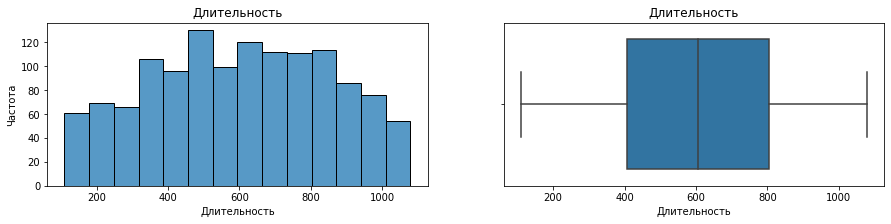

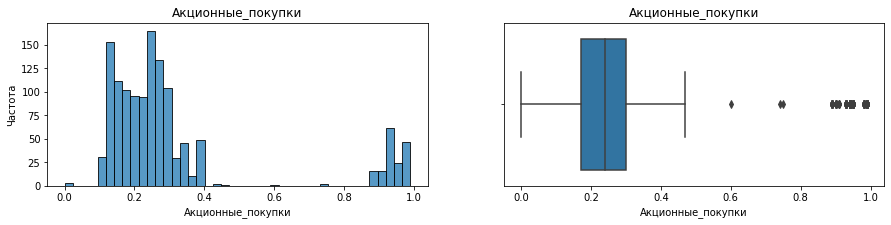

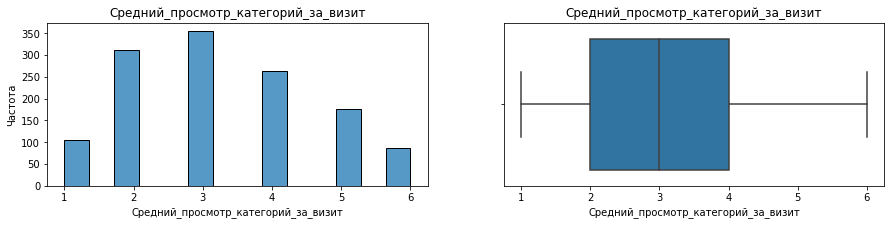

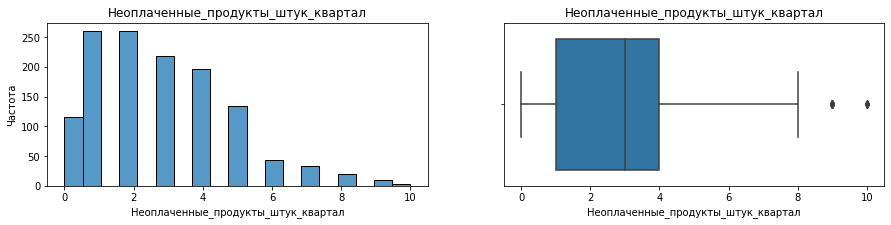

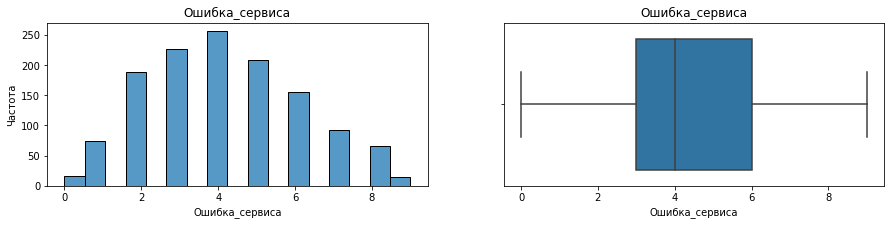

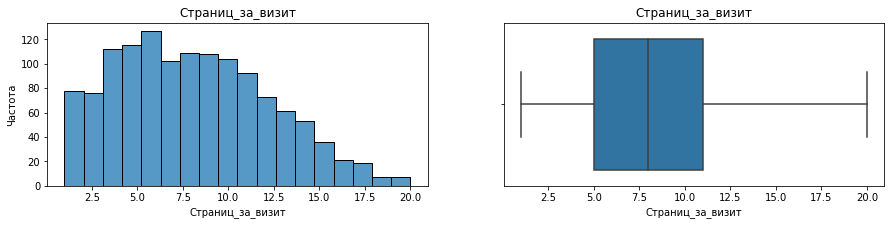

In [31]:
for i in col_features:
    plot_col(market_file, i)

Проверим количественные признаки на нормальность с помощью теста Шапиро-Уилка:

In [32]:
for i in col_features:
    stat, p_val = shapiro(market_file[i])
    if p_val < 0.05: 
        print(f'Распределение {i} не нормальное')
    else: 
        print(f'Распределение {i} нормальное')

Распределение Маркет_актив_6_мес не нормальное
Распределение Маркет_актив_тек_мес не нормальное
Распределение Длительность не нормальное
Распределение Акционные_покупки не нормальное
Распределение Средний_просмотр_категорий_за_визит не нормальное
Распределение Неоплаченные_продукты_штук_квартал не нормальное
Распределение Ошибка_сервиса не нормальное
Распределение Страниц_за_визит не нормальное


### market_money

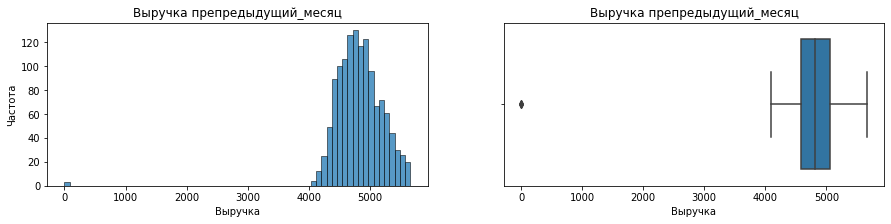

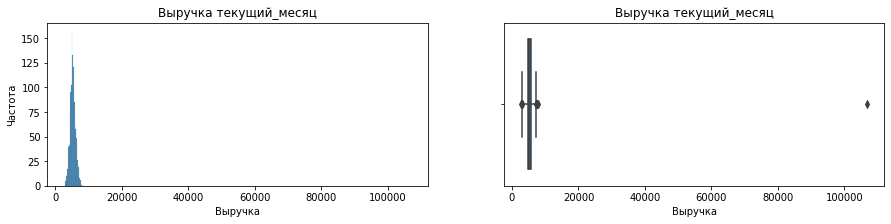

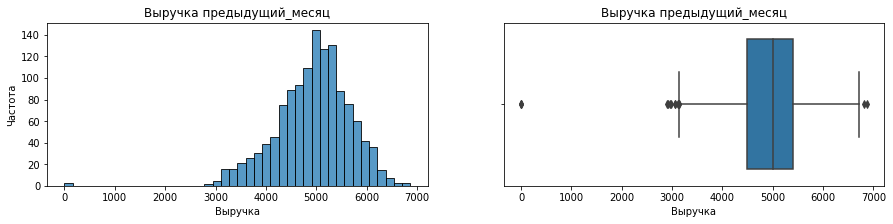

In [33]:
for i in market_money['Период'].unique():
    plot_col(market_money.query('Период == @i'), 'Выручка', i)

Выбросы единичны, смысловой нагрузки не несут, поэтому удалим их.

In [34]:
market_money[market_money['Период'] == 'препредыдущий_месяц'] = \
market_money[(market_money['Период'] == 'препредыдущий_месяц') & (market_money['Выручка'] >= 3500)]
market_money[market_money['Период'] == 'предыдущий_месяц'] = \
market_money[(market_money['Период'] == 'предыдущий_месяц') & (market_money['Выручка'] >= 2500)]
market_money[market_money['Период'] == 'текущий_месяц'] = \
market_money[(market_money['Период'] == 'текущий_месяц') & (market_money['Выручка'] <= 10000)]

market_money.dropna(subset=['Период'], inplace=True)

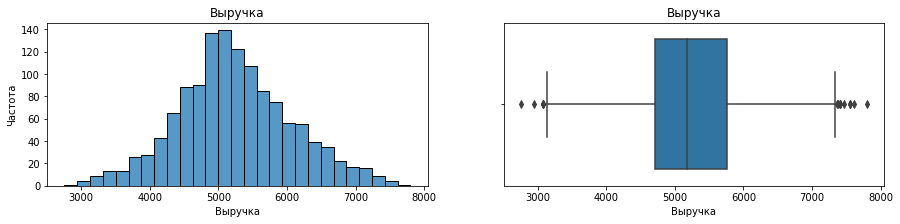

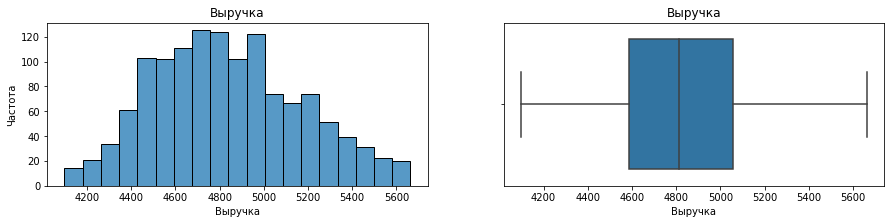

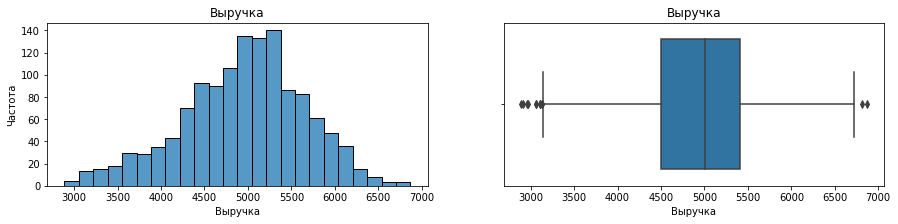

In [35]:
for i in market_money['Период'].unique():
    plot_col(market_money.query('Период == @i'), 'Выручка')

### market_time

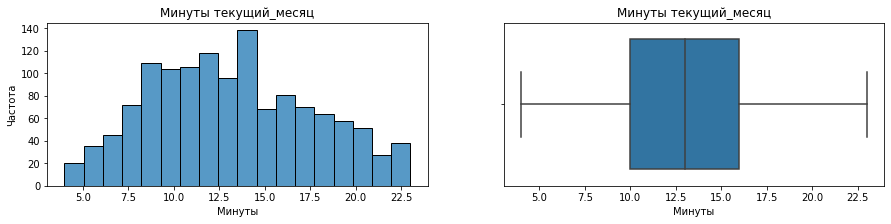

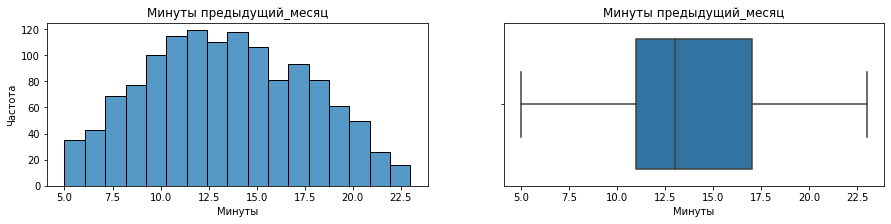

In [36]:
for i in market_time['Период'].unique():
    plot_col(market_time.query('Период == @i'), 'Минуты', i)

Среднее время, проведенное на сайте, не изменилось по сравнению с предыдущим месяцем.

### money

                  id      Прибыль
count    1300.000000  1300.000000
mean   215997.500000     3.996631
std       375.421985     1.013722
min    215348.000000     0.860000
25%    215672.750000     3.300000
50%    215997.500000     4.045000
75%    216322.250000     4.670000
max    216647.000000     7.430000


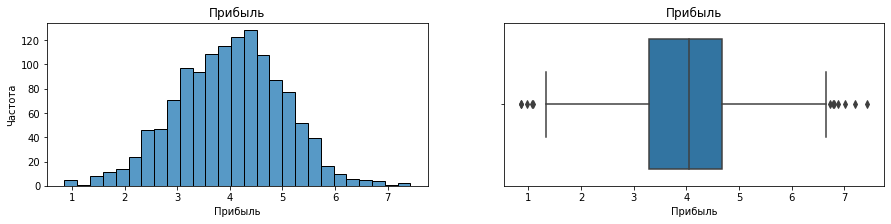

In [37]:
print(money.describe())
plot_col(money, 'Прибыль')

От каждого покупателя в среднем магазин получает 4 единицы. Максимальная и минимальная прибыли достигают 7.5 и 0.8 единиц соответственно.

### Отбор активных пользователей

In [38]:
print(f'market_file = {market_file.shape} \
      market_money = {market_money.shape} \
      market_time = {market_time.shape} \
      money = {money.shape}')

inf = list(market_money.query('Выручка == 0')['id'])
market_file = market_file.query('id != @inf')
market_money = market_money.query('id != @inf')
market_time = market_time.query('id != @inf')
money = money.query('id != @inf')

print(f'market_file = {market_file.shape} \
      market_money = {market_money.shape} \
      market_time = {market_time.shape} \
      money = {money.shape}')

market_file = (1300, 13)       market_money = (3893, 3)       market_time = (2600, 3)       money = (1300, 2)
market_file = (1300, 13)       market_money = (3893, 3)       market_time = (2600, 3)       money = (1300, 2)


### Итог:
- Количественные признаки: 'Маркет актив 6 мес', 'Маркет актив тек мес', 'Длительность', 'Акционные покупки', 'Средний просмотр категорий за визит', 'Неоплаченные продукты штук квартал', 'Ошибка сервиса', 'Страниц за визит'. Распределены не нормально.
- Покупательская способность сохранилась на прежнем уровне примерно в 60% случаев;
- Премиум сектор в три раза меньше стандартного;
- Рассылка охватывает 75% покупателей;
- Популярные категории: товары для детей, домашний текстиль, косметика и аксессуары, техника для касоты и здоровья, мелкая бытовая техника и электроника, кухонная посуда; 
- В перечне популярных товаров преимущественно встречаются категории, которые чаще покупают представители женской аудитории;
- В среднем на одного покупателя приходилось 4 маркетинговых коммуникаций компании. Ситуация не изменилась в текущем месяце;
- Среднестатистический пользователь зарегистрирован на сайте 600 дней, то есть почти 2 года;
- В среднем покупатели отдают предпочтение акционным товарам только в 20% случаях. Есть те, кто покупает только товары по акции;
- За один визит покупатели просматривают по 2-3 категории;
- У большинства покупателей в корзине лежит по 1-2 неоплаченных товаров;
- Сайт работает без сбоев лишь в 17 случаях из 1300. В среднем при посещении сайта пользователь сталкивается с 4 сбоями;
- За один визит в среднем просматривается по 4-5 страниц;
- В текущем месяце замечен рост выручки на 500 единиц по сравнению с предыдущим месяцем;
- Среднее время на сайте в предыдущем и текущем месяцах - 13 минут;
- От каждого покупателя в среднем магазин получает 4 единицы. Максимальная и минимальная прибыли достигают 7.5 и 0.8 единиц соответственно;
- Удалены единичные выбросы из данных Выручки по каждому периоду;
- Исключены из списков три пользователя, для которых нет данных покупок за последние три месяца.

<a id='section6'></a>
## Объединение таблиц 

In [39]:
for i in market_money['Период'].unique():
    market_file = market_file.merge(market_money.query('Период == @i'), on='id', how='left')
market_file = market_file.drop(labels=['Период_x', 'Период_y', 'Период'], axis=1)
market_file = market_file.rename(columns={'Выручка_x':'Выручка_пред', 'Выручка_y':'Выручка_тек', 'Выручка': 'Выручка_препред'})

In [40]:
for i in market_time['Период'].unique():
    market_file = market_file.merge(market_time.query('Период == @i'), on='id', how='left')
market_file = market_file.drop(labels=['Период_x', 'Период_y'], axis=1)
market_file = market_file.rename(columns={'Минуты_x':'Минуты_пред', 'Минуты_y':'Минуты_тек'})

In [41]:
market_file.head()

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_пред,Выручка_тек,Выручка_препред,Минуты_пред,Минуты_тек
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5,3293.1,NaN,NaN,14,13
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,4971.6,4472.0,5216.0,10,12
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,5058.4,4826.0,5457.5,13,8
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,6610.4,4793.0,6158.0,13,11
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,5872.5,4594.0,5807.5,11,8


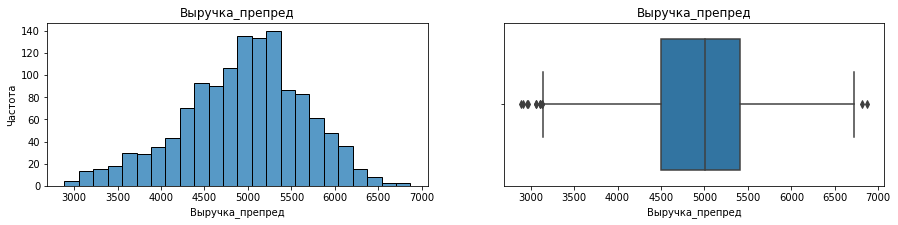

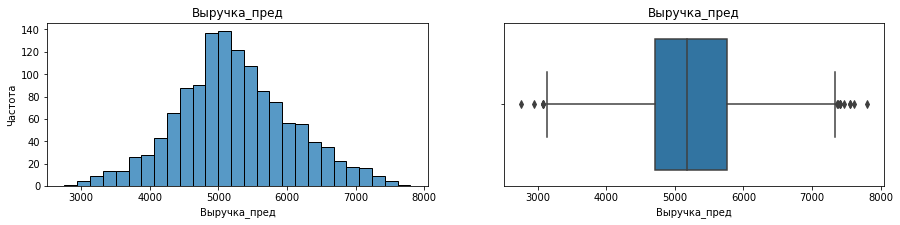

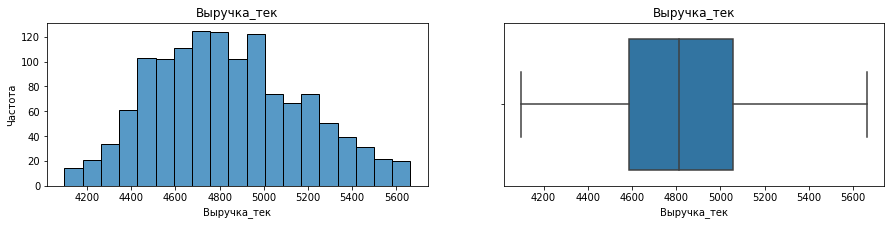

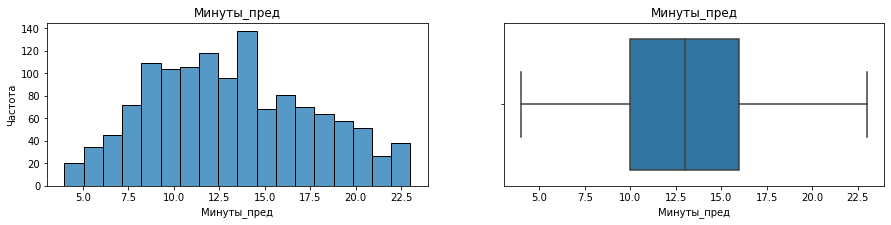

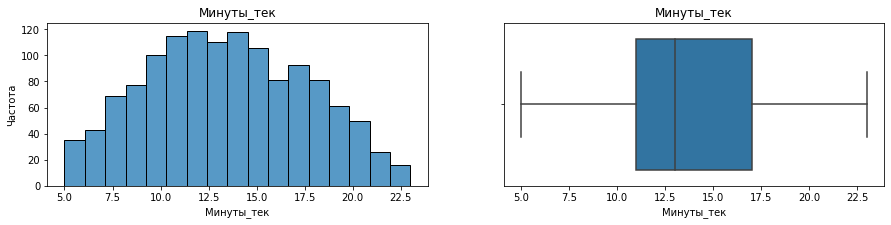

In [42]:
new_features = ['Выручка_препред', 'Выручка_пред', 'Выручка_тек', 'Минуты_пред', 'Минуты_тек']
for i in new_features:
    plot_col(market_file, i)

Проверим количественные признаки на нормальность с помощью теста Шапиро-Уилка:

In [43]:
for i in new_features:
    stat, p_val = shapiro(market_file[i])
    if p_val < 0.05: 
        print(f'Распределение {i} не нормальное')
    else: 
        print(f'Распределение {i} нормальное')

Распределение Выручка_препред нормальное
Распределение Выручка_пред нормальное
Распределение Выручка_тек нормальное
Распределение Минуты_пред не нормальное
Распределение Минуты_тек не нормальное


In [44]:
market_file.isna().sum()

id                                     0
Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
Выручка_пред                           1
Выручка_тек                            3
Выручка_препред                        3
Минуты_пред                            0
Минуты_тек                             0
dtype: int64

In [45]:
market_file.dropna(subset=['Выручка_пред', 'Выручка_тек', 'Выручка_препред'], inplace=True)

### Итог:
- Таблицы объединены;
- Удалены выбросы;
- Новые признаки проверены на нормальность, гипотеза не подтвердилась для 'Минуты пред' и 'Минуты тек'.

<a id='section7'></a>
## Корреляционный анализ 

Количественные признаки распределены не нормально. Будем использовать коэффициент корреляции $\phi_K$, так как он согласованно работает между категориальными, порядковыми и интервальными переменными и фиксирует нелинейную зависимость.

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_пред', 'Выручка_тек', 'Выручка_препред', 'Минуты_пред', 'Минуты_тек']


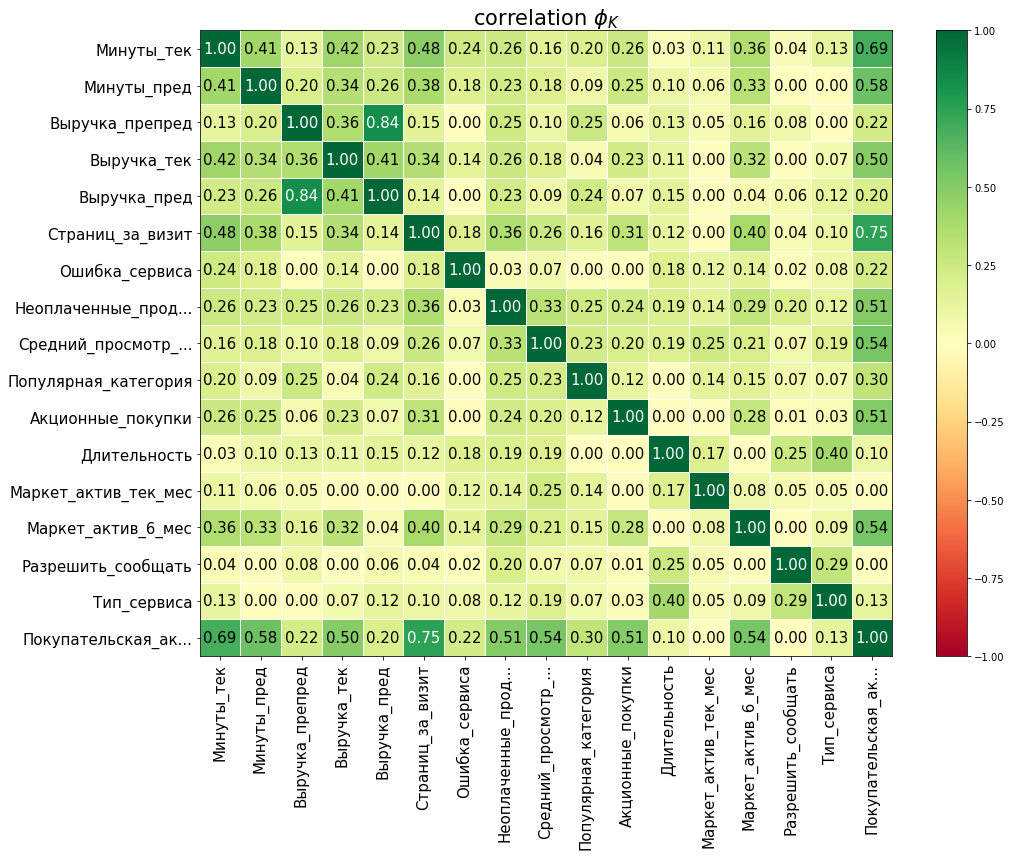

In [46]:
market_file = market_file.set_index('id')

phik_overview = market_file.phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

### Итог
Все коэффициенты корреляции не превышают 0.9, поэтому никакие признаки трогать не будем. Однако, стоит отметить, что самые высокие коэфффициенты между "Выручка пред", "Выручка препред" (0.84) и Покупательская активность, Страниц за визит (0.75).

<a id='section8'></a>
## Использование пайплайнов

In [47]:
X = market_file.drop('Покупательская_активность', axis=1)
y = market_file['Покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25, stratify=y)

In [48]:
ohe_code = ['Тип_сервиса', 'Популярная_категория']
ord_code = ['Разрешить_сообщать']
num_code = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
            'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 
            'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 
            'Страниц_за_визит', 'Выручка_пред', 'Выручка_тек',
            'Выручка_препред', 'Минуты_пред', 'Минуты_тек']

In [49]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
)

In [50]:
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=[['да', 'нет']], handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [51]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_code),
        ('ord', ord_pipe, ord_code),
        ('num', MinMaxScaler(), num_code)
    ],
    remainder='passthrough'
)

In [52]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=42))
    ]
)

In [53]:
param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    'models': None
}

In [54]:
RANDOM_STATE = 42
param_distributions = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly', probability=True)],
        'models__degree': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

В качестве оценки модели используем метрику ROC-AUC, так как нам одинаково важно учитывать TPR и FPR в данной задаче.

In [55]:
import warnings
warnings.filterwarnings('ignore')

grid = GridSearchCV(pipe_final,
                   param_grid=param_distributions,
                   cv=5,
                   scoring='roc_auc',
                   n_jobs=-1)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False))]),
                                                                         ['Тип_сервиса',
                                                                          'Популярная_категория']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',...
                         {'models': [SVC(kernel='poly', probability=True,
                                         random_state=42)],
                          'models__degree': range(2, 3),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=42,
                                                        solver='liblinear')],
                          'models__C': range(1, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [56]:
print(f'Лучшая модель и её параметры: {grid.best_params_}')
print(f'Метрика ROC-AUC для лучшей модели: {round(grid.best_score_, 3)}')

Лучшая модель и её параметры: {'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), 'models__C': 1, 'preprocessor__num': MinMaxScaler()}
Метрика ROC-AUC для лучшей модели: 0.898


In [57]:
y_pred = grid.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_pred), 3)}')

Метрика ROC-AUC на тестовой выборке: 0.918


### Итог:

- Были написаны пайплайны для кодирования категориальных признаков по средствам OneHotEncoding и OrdinalEncoding;
- Были написаны пайпланы для масштабирования числовых признаков с помощью MinMaxScaler;
- Первые два пункта были объединены в один процесс с помощью ColumnTransformer;
- Были подобраны параметры для четырех моделей: DecisionTreeClassifier, KNeighborsClassifier, SVC, LogisticRegression через сетку GridSearchCV;
- В качестве оценки модели использовали метрику ROC-AUC;
- Лучшая модель и её параметры: {'models': LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear'), 'models__C': 1, 'preprocessor__num': MinMaxScaler()};
- Метрика ROC-AUC на тренировочной выборке: 0.898;
- Метрика ROC-AUC на тестовой выборке: 0.918.

<a id='section9'></a>
## Анализ важности признаков

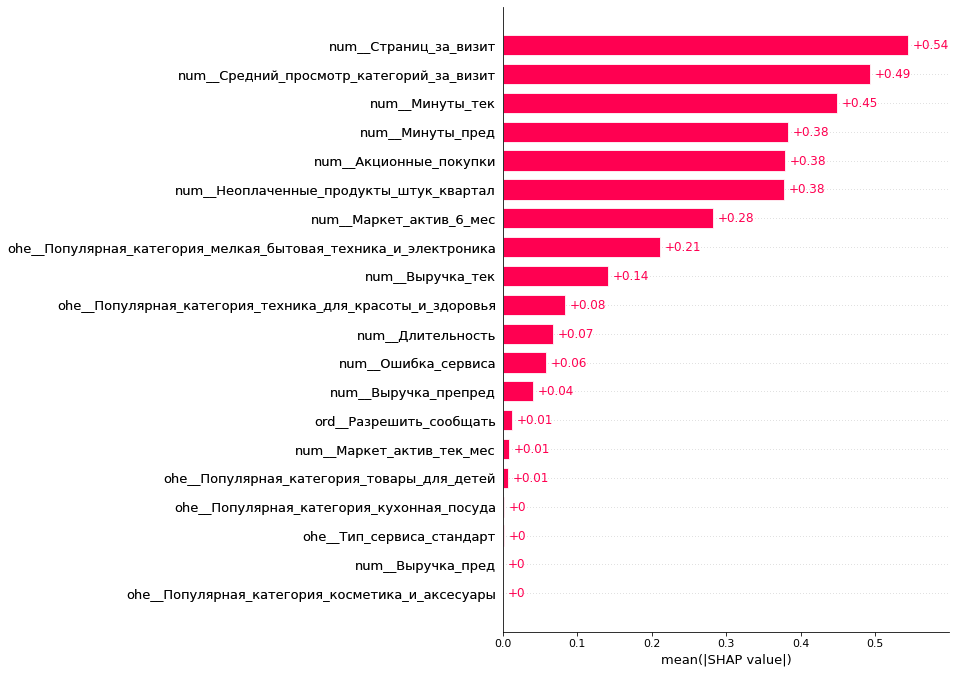

In [58]:
X_train_encoded = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.LinearExplainer(grid.best_estimator_.named_steps['models'], X_train_encoded)

X_test_encoded = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

X_test_encoded = pd.DataFrame(X_test_encoded, columns=feature_names)
 
shap_values = explainer(X_test_encoded)
 
shap.plots.bar(shap_values, max_display=30)

### Итог:
- Наибольшее влияние имеют следующие признаки (в порядке уменьшения влияния): Страниц за визит, Средний просмотр категорий за визит, Минуты тек, Минуты пред, Акционные покупки, Неоплаченные продукты штук квартал, Маркет актив 6 мес, Популярная категория (бытовая техника и электроника);
- Наименее влиятельными оказались признаки относящиеся к Популярная категория (товары для детей, кухонная посуда, косметика и аксесуары, техника для красоты и здоровья), Выручка пред, Тип сервиса, Разрешить сообщать, Маркет актив тек мес.

<a id='section10'></a>
## Сегментация покупателей

In [59]:
y_train_proba = grid.predict_proba(X_train)[:,1]
y_test_proba = grid.predict_proba(X_test)[:,1]

In [60]:
X_train_seg = X_train.copy()
X_test_seg = X_test.copy()
X_train_seg['Вероятность_снижения'] = y_train_proba
X_test_seg['Вероятность_снижения'] = y_test_proba

df = pd.concat([X_train_seg, X_test_seg])
money = money.set_index('id')
df = df.join(money)

In [61]:
df_seg = df[(df['Прибыль'] >= 2) & (df['Вероятность_снижения'] >= 0.7)]

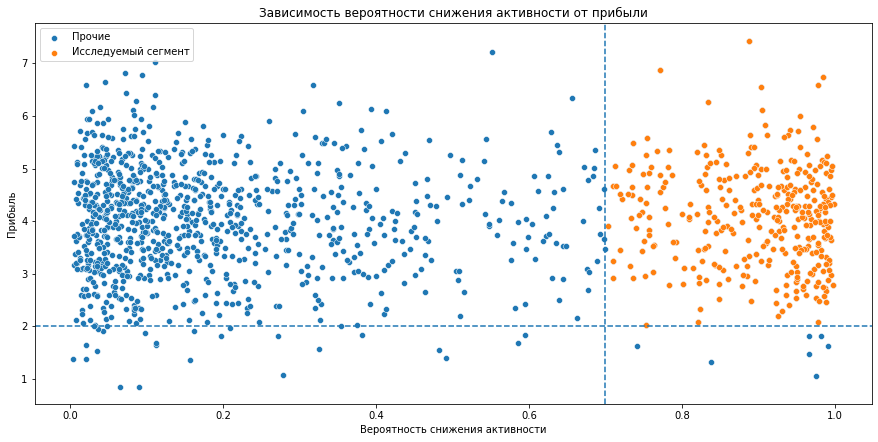

In [62]:
fig = plt.figure(figsize=(15,7))
sns.scatterplot(data=df, y='Прибыль', x='Вероятность_снижения', label='Прочие')
sns.scatterplot(data=df_seg, y='Прибыль', x='Вероятность_снижения', label='Исследуемый сегмент')
plt.legend()
plt.axvline(x=0.7, linestyle='--')
plt.axhline(y=2, linestyle='--')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль')
plt.title('Зависимость вероятности снижения активности от прибыли')
plt.show()

In [63]:
df_sale_buyers = df_seg[df_seg['Акционные_покупки'] >= 0.5]
df_seg['Исследуемая_группа'] = (df_seg['Акционные_покупки'] >= 0.5)

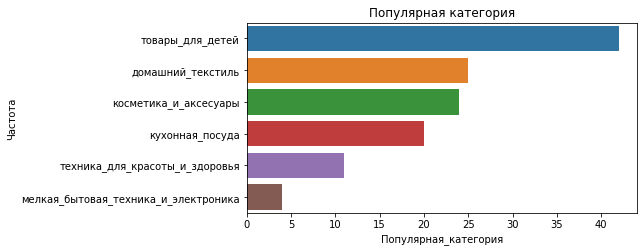

In [64]:
plt.figure(figsize=(7, 3.5))
inf = df_sale_buyers['Популярная_категория'].value_counts()
ax = sns.barplot(x=inf, y=inf.index)
ax.set_ylabel('Частота')
ax.set_title('Популярная категория')
plt.show()

Товары для детей является самой популярной категорией в данном сегменте покупателей, видимо, из-за того, что являются расходниками.

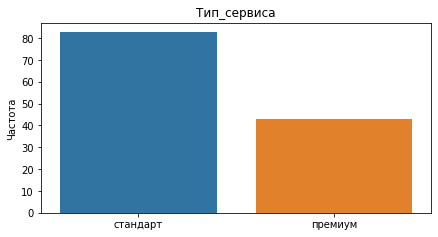

In [65]:
plot_cat(df_sale_buyers, 'Тип_сервиса')

В большинстве своем, выбирают сервис стандарт, премиум составляет половину от стандарта.

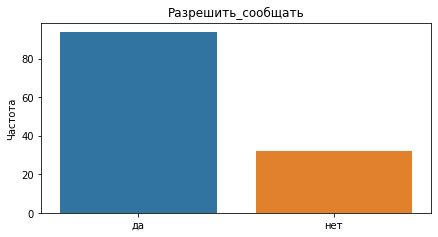

In [66]:
plot_cat(df_sale_buyers, 'Разрешить_сообщать')

Видимо, для отслеживания акций представители данного сегмента чаще подписаны на рассылки.

In [67]:
def hist_plot(df, column, target):
    plt.figure(figsize=(7, 3.5))
    plot = sns.histplot(df, bins=20, kde=True, hue=target, x=column, stat='density', common_norm=False)
    plot.set_title(column)
    plot.set_ylabel('Частота')
    plt.show()

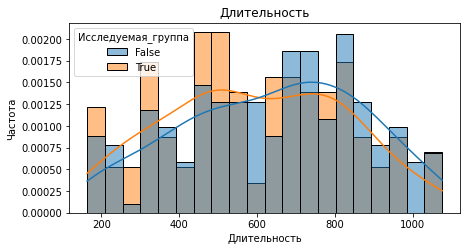

In [68]:
hist_plot(df_seg, 'Длительность', 'Исследуемая_группа')

Пользователи данной группы зарегистрированы на сайте в среднем около полутора года, хотя среди представителей данного сегмента есть и те, кто является постоянными покупателями на протяжении свыше трёх лет.

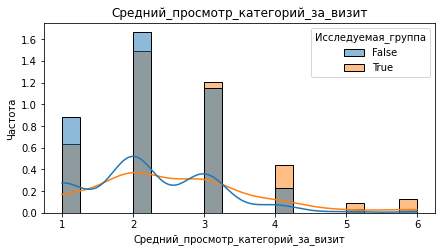

In [69]:
hist_plot(df_seg, 'Средний_просмотр_категорий_за_визит', 'Исследуемая_группа')

Пользователи исследуемой группы просматривают в среднем больше категорий товаров, чем другие в сегменте, видимо, в поиске акций.

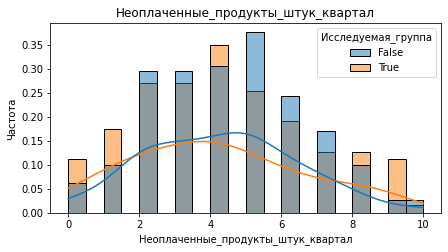

In [70]:
hist_plot(df_seg, 'Неоплаченные_продукты_штук_квартал', 'Исследуемая_группа')

Неоплаченных товаров в корзине пользователей данной группы в среднем больше, чем у других в сегменте. Видимо, многие товары просто откладываются в ожидании скидки.

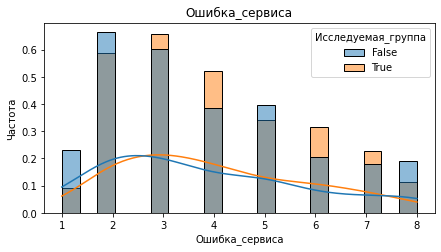

In [71]:
hist_plot(df_seg, 'Ошибка_сервиса', 'Исследуемая_группа')

С ошибками сервиса исследуемые пользователи встречаются чаще, чем другие. Это может заставлять отказываться от сервиса в пользу более устойчивых сайтов.

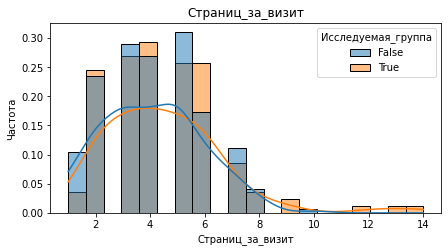

In [72]:
hist_plot(df_seg, 'Страниц_за_визит', 'Исследуемая_группа')

За один визит покупатели исследуемой группы просматривают больше страниц, чем другие, так как заходят в поиске акций.

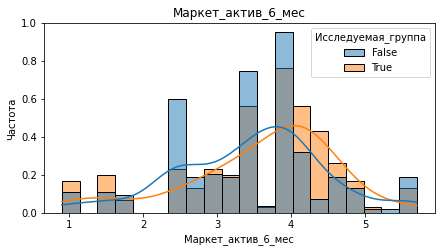

None

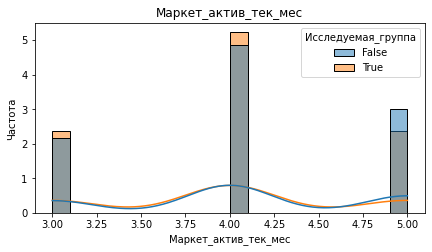

In [73]:
display(hist_plot(df_seg, 'Маркет_актив_6_мес', 'Исследуемая_группа'))
hist_plot(df_seg, 'Маркет_актив_тек_мес', 'Исследуемая_группа')

Исследуемые покупатели получают несильно больше внимания от отдела маркетинга, чем другие в данном сегменте.

### Итог:
- Для дополнительного исследования был взят сегмент пользователей, которые приносят больше 2 единиц прибыли и имеют свыше 70% вероятности по снижению покупательской активности; Из данного сегмента была выделена группа пользователей, которые совершают акционные покупки более чем в 50% случаях.
- Среднестатистический представитель данной группы:
    - Покупает товары для детей, домашний текстиль, косметику и аксесуары;
    - Пользуется стандартным сервисом;
    - Открыт для рассылок;
    - Является постоянным покупателем на протяжении 1.5 лет;
    - Просматривает 5-6 категорий товаров за один визит;
    - Откладывает по 8-10 товаров для оплаты в будущем;
    - Просматривает 12-14 страницы за визит.
- В ходе анализа было выявлено, что вся деятельность исследуемых пользователей на сайте направлена исключительно на покупку акционных товаров в то время, как данный сегмент покупателей слабо выделен маркетинговым отделом. В связи с этим, целесообразно вести счёт наиболее часто откладываемым товарам и проводить ежемесячные акции на них и смежные варианты. Также, необходимо ввести дополнительное уведомление пользователей данного сегмента об акциях, например, смс-уведомления или телеграмм канал с новостями о последних акциях. И наконец, важно исправить ошибки сервиса, так как именно они могут послужить причиной потери клиентов в целом и представителей данной группы сегмента в частности.

<a id='section11'></a>
## Общий вывод
1. Описание данных:
    - market_file.csv Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении;
    - market_money.csv Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом;
    - market_time.csv Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода;
    - money.csv Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
2. Предобработка данных:
    - Названия столбцов приведены к одному виду;
    - Устранены опечатки в данных;
    - Данные проверены на дубликаты;
    - Данные проверены на пропуски.
3. Исследовательский анализ данных:
    - Количественные признаки: 'Маркет актив 6 мес', 'Маркет актив тек мес', 'Длительность', 'Акционные покупки', 'Средний просмотр категорий за визит', 'Неоплаченные продукты штук квартал', 'Ошибка сервиса', 'Страниц за визит'. Распределены не нормально.
    - Покупательская способность сохранилась на прежнем уровне примерно в 60% случаев;
    - Премиум сектор в три раза меньше стандартного;
    - Рассылка охватывает 75% покупателей;
    - Популярные категории: товары для детей, домашний текстиль, косметика и аксессуары, техника для касоты и здоровья, мелкая бытовая техника и электроника, кухонная посуда; 
    - В перечне популярных товаров преимущественно встречаются категории, которые чаще покупают представители женской аудитории;
    - В среднем на одного покупателя приходилось 4 маркетинговых коммуникаций компании. Ситуация не изменилась в текущем месяце;
    - Среднестатистический пользователь зарегистрирован на сайте 600 дней, то есть почти 2 года;
    - В среднем покупатели отдают предпочтение акционным товарам только в 20% случаях. Есть те, кто покупает только товары по акции;
    - За один визит покупатели просматривают по 2-3 категории;
    - У большинства покупателей в корзине лежит по 1-2 неоплаченных товаров;
    - Сайт работает без сбоев лишь в 17 случаях из 1300. В среднем при посещении сайта пользователь сталкивается с 4 сбоями;
    - За один визит в среднем просматривается по 4-5 страниц;
    - В текущем месяце замечен рост выручки на 500 единиц по сравнению с предыдущим месяцем;
    - Среднее время на сайте в предыдущем и текущем месяцах - 13 минут;
    - От каждого покупателя в среднем магазин получает 4 единицы. Максимальная и минимальная прибыли достигают 7.5 и 0.8 единиц соответственно;
    - Удалены единичные выбросы из данных Выручки по каждому периоду;
    - Исключены из списков три пользователя, для которых нет данных покупок за последние три месяца.
4. Корреляционный анализ:
    - Количественные признаки распределены не нормально. Будем использовать коэффициент корреляции  $\phi_K$, так как он согласованно работает между категориальными, порядковыми и интервальными переменными и фиксирует нелинейную зависимость.
    - Все коэффициенты корреляции не превышают 0.9, поэтому никакие признаки трогать не будем. Однако, стоит отметить, что самые высокие коэфффициенты между "Выручка пред", "Выручка препред" (0.84) и Покупательская активность, Страниц за визит (0.75).
5. Использование пайплайнов:
    - Были написаны пайплайны для кодирования категориальных признаков по средствам OneHotEncoding и OrdinalEncoding;
    - Были написаны пайпланы для масштабирования числовых признаков с помощью MinMaxScaler;
    - Первые два пункта были объединены в один процесс с помощью ColumnTransformer;
    - Были подобраны параметры для четырех моделей: DecisionTreeClassifier, KNeighborsClassifier, SVC, LogisticRegression через сетку GridSearchCV;
    - В качестве оценки модели использовали метрику ROC-AUC;
    - Лучшая модель и её параметры: {'models': LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear'), 'models__C': 1, 'preprocessor__num': MinMaxScaler()};
    - Метрика ROC-AUC на тренировочной выборке: 0.898;
    - Метрика ROC-AUC на тестовой выборке: 0.918.
6. Анализ важности признаков:
    - Наибольшее влияние имеют следующие признаки (в порядке уменьшения влияния): Страниц за визит, Средний просмотр категорий за визит, Минуты тек, Минуты пред, Акционные покупки, Неоплаченные продукты штук квартал, Маркет актив 6 мес, Популярная категория (бытовая техника и электроника);
    - Наименее влиятельными оказались признаки относящиеся к Популярная категория (товары для детей, кухонная посуда, косметика и аксесуары, техника для красоты и здоровья), Выручка пред, Тип сервиса, Разрешить сообщать, Маркет актив тек мес.
7. Сегментация покупателей:
    - Для дополнительного исследования был взят сегмент пользователей, которые приносят больше 2 единиц прибыли и имеют свыше 70% вероятности по снижению покупательской активности; Из данного сегмента была выделена группа пользователей, которые совершают акционные покупки более чем в 50% случаях.
    - Среднестатистический представитель данной группы:
        - Покупает товары для детей, домашний текстиль, косметику и аксесуары;
        - Пользуется стандартным сервисом;
        - Открыт для рассылок;
        - Является постоянным покупателем на протяжении 1.5 лет;
        - Просматривает 5-6 категорий товаров за один визит;
        - Откладывает по 8-10 товаров для оплаты в будущем;
        - Просматривает 12-14 страницы за визит.
    - В ходе анализа было выявлено, что вся деятельность исследуемых пользователей на сайте направлена исключительно на покупку акционных товаров в то время, как данный сегмент покупателей слабо выделен маркетинговым отделом. В связи с этим, целесообразно вести счёт наиболее часто откладываемым товарам и проводить ежемесячные акции на них и смежные варианты. Также, необходимо ввести дополнительное уведомление пользователей данного сегмента об акциях, например, смс-уведомления или телеграмм канал с новостями о последних акциях. И наконец, важно исправить ошибки сервиса, так как именно они могут послужить причиной потери клиентов в целом и представителей данной группы сегмента в частности.